In [1]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist 
from tensorflow.keras.utils import plot_model 
from tensorflow.keras import backend as K 

In [2]:
import numpy as np
import matplotlib.pyplot as plt 

In [3]:
#loading dataset MNIST 

(x_train, _), (x_test,_) = mnist.load_data()

In [4]:
#reshape to (28,28,1) and normalize input images 

image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size,1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])

x_train = x_train.astype('float32') /255 
x_test = x_test.astype('float32') / 255


In [5]:
#network parameters 

input_shape = (image_size, image_size, 1)
batch_size = 32 
kernel_size = 3
latent_dim = 16 

#encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

In [6]:
#Building the autoencode MODEL 

#First - the Encoder part 

inputs = Input(shape=input_shape, name='encoder_input')
x = inputs 

#stack of Conv2D(32) - Conv2d(64)
for filters in layer_filters:
    
    x = Conv2D(filters = filters,
              kernel_size=kernel_size,
              activation='relu',
              strides = 2,
              padding='same')(x)

In [7]:
#Shape info needed to build decoder model so we dont 
#hand computation the input to the decoder's first
# Conv2DTranspose will have this shpae
#shape is (7,7,64) which is processed by the decoder
#back to (28,28,1)

shape = K.int_shape(x)

In [8]:
#generate latent vector 

x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

#instantiate encoder model 

encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 latent_vector (Dense)       (None, 16)                50192     
                                                                 
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


In [9]:
plot_model(encoder, to_file='encoder.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [10]:
!pip install pydot

In [11]:
!pip install graphviz

In [12]:
plot_model(encoder, to_file='encoder.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [13]:
#Build the decoder model

latent_inputs = Input(shape=(latent_dim,),name='decoder_input')

#use the shape (7,7,64) that was earlier saved
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)

#from vector to suitable shape for tansposed conv
x = Reshape((shape[1], shape[2],shape[3]))(x)

In [14]:
#stack of Conv2DTranspose(64)-conv2DTranpose(32)

for filters in layer_filters[::-1]:
    
    x = Conv2DTranspose(filters=filters,
                       kernel_size=kernel_size,
                       activation='relu',
                       strides=2,
                       padding='same')(x)

In [15]:
#Reconstruct the input

outputs = Conv2DTranspose(filters=1,
                         kernel_size=kernel_size,
                         activation='sigmoid',
                         padding='same',
                         name='decoder_output')(x)

In [16]:
#instantiate decoder model 
decoder = Model(latent_inputs,outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 16)]              0         
                                                                 
 dense (Dense)               (None, 3136)              53312     
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 decoder_output (Conv2DTrans  (None, 28, 28, 1)        289 

In [17]:
#autoencoder = encoder + decoder
#instantiate autoencoder model 

autoencoder = Model(inputs,
                   decoder(encoder(inputs)),
                   name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 16)                69008     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         108993    
                                                                 
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________


In [18]:
plot_model(autoencoder, to_file='autoencoder.png',
          show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [19]:
#mean square error loss function and Adam optimizer 

autoencoder.compile(loss='mse',optimizer='adam')

In [20]:
#train the autoencoder
autoencoder.fit(x_train, x_train,
               validation_data=(x_test,x_test),
               epochs=20,
               batch_size=batch_size)

Epoch 1/20
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0206 - val_loss: 0.0105
Epoch 2/20
1875/1875 [==============================] - 37s 20ms/step - loss: 0.0098 - val_loss: 0.0090
Epoch 3/20
1875/1875 [==============================] - 40s 22ms/step - loss: 0.0087 - val_loss: 0.0082
Epoch 4/20
1875/1875 [==============================] - 46s 24ms/step - loss: 0.0081 - val_loss: 0.0079
Epoch 5/20
1875/1875 [==============================] - 55s 29ms/step - loss: 0.0077 - val_loss: 0.0075
Epoch 6/20
1875/1875 [==============================] - 67s 36ms/step - loss: 0.0074 - val_loss: 0.0075
Epoch 7/20
1875/1875 [==============================] - 57s 30ms/step - loss: 0.0072 - val_loss: 0.0073
Epoch 8/20
1875/1875 [==============================] - 56s 30ms/step - loss: 0.0070 - val_loss: 0.0072
Epoch 9/20
1875/1875 [==============================] - 62s 33ms/step - loss: 0.0069 - val_loss: 0.0071
Epoch 10/20
1875/1875 [==============================] - 58s 31m

In [21]:
#predict the autoencoder output from test data

x_decoded = autoencoder.predict(x_test)

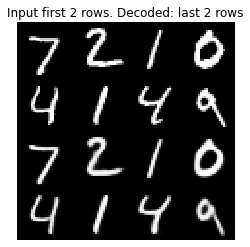

In [22]:
#display the first 10 input and decoded images

imgs = np.concatenate([x_test[:8], x_decoded[:8]])
imgs = imgs.reshape((4,4,image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title("Input first 2 rows. Decoded: last 2 rows")
plt.imshow(imgs, interpolation='none',cmap='gray')
plt.savefig('input_n_decoded.png')
plt.show()

#### 